In [1]:
%%capture
!pip install grad-cam
# https://github.com/jacobgil/pytorch-grad-cam

In [2]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.image import show_cam_on_image

import torch
import cv2
import torchvision
import matplotlib.pyplot as plt

In [3]:
# Define the CAM methods
cam_methods = {
    'GradCAM': GradCAM,
    # 'GradCAM++': GradCAMPlusPlus,
    # 'HiResCAM': HiResCAM,
    # 'ScoreCAM': ScoreCAM,
    # 'AblationCAM': AblationCAM,
    # 'XGradCAM': XGradCAM,
    # 'EigenCAM': EigenCAM,
    'FullGrad': FullGrad
}

In [5]:
# Load the image
rgb_img = cv2.imread('/content/1_kc-k_j53HOJH_sifhg4lHg.webp') / 255.0

resize_to = (224, 224)

transform_norm = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Resize(size=resize_to, antialias=True),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Note: input_tensor must be 4D - (batch_size, channels, height, width)
input_tensor = transform_norm(rgb_img).unsqueeze(0)

torch.Size([1, 3, 224, 224])

In [6]:
model = torchvision.models.resnet50(weights='DEFAULT').double()
target_layers = [model.layer4[-1]]

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 95.0MB/s]


In [7]:
# Construct the CAM objects once for each method
cams = {}
for cam_name, cam_method in cam_methods.items():
    cams[cam_name] = cam_method(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())


In [8]:
# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

# targets = [ClassifierOutputTarget(281)]
targets = None

In [9]:
# Create a dictionary to store the visualizations
visualizations = {}

# Generate visualizations for each CAM method
for cam_name, cam in cams.items():
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

    # In this example grayscale_cam has only one image in the batch:
    grayscale_cam = grayscale_cam[0, :]
    visualization = show_cam_on_image(cv2.resize(rgb_img, resize_to), grayscale_cam, use_rgb=True)
    visualizations[cam_name] = visualization

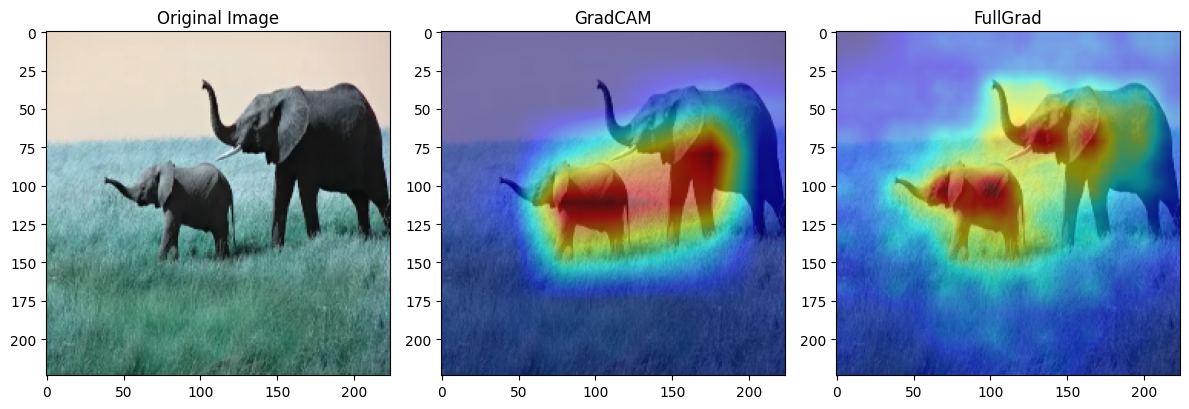

In [10]:
# Plot the original image and all the visualizations
num_visualizations = len(visualizations)
fig, axs = plt.subplots(1, num_visualizations + 1, figsize=(4 * (num_visualizations + 1), 4))
axs[0].imshow(cv2.resize(rgb_img, resize_to))
axs[0].set_title('Original Image')

for i, (cam_name, visualization) in enumerate(visualizations.items()):
    axs[i + 1].imshow(visualization)
    axs[i + 1].set_title(cam_name)

plt.tight_layout()
plt.show()